In [7]:
# Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re #regular expressions
import os
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pyLDAvis.gensim_models
#import en_core_web_md #sm/md/lg size
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import warnings

# Increase width of columns on dataframe
pd.set_option('display.max_colwidth', None)
# Visualise inside a notebook
pyLDAvis.enable_notebook()
# Ignore warnings
warnings.filterwarnings('ignore')

## Data exploration


https://www.analyticsvidhya.com/blog/2021/06/eda-exploratory-data-analysis-with-python/
https://www.kaggle.com/code/nextbigwhat/eda-for-categorical-variables-a-beginner-s-way
https://www.analyticsvidhya.com/blog/2021/07/15-python-built-in-functions-which-you-should-know-while-learning-data-science/?utm_source=reading_list&utm_medium=https://www.analyticsvidhya.com/blog/2015/06/infographic-cheat-sheet-data-exploration-python/
https://www.kaggle.com/discussions/getting-started/254970
https://www.kaggle.com/code/datark1/eda-images-processing-and-exploration#1.-Images-metadata

In [50]:
# Load data from a CSV file into a DataFrame
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_train.head(30)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [51]:
# Fetch the general information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [52]:
# Count unique values in a column 
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

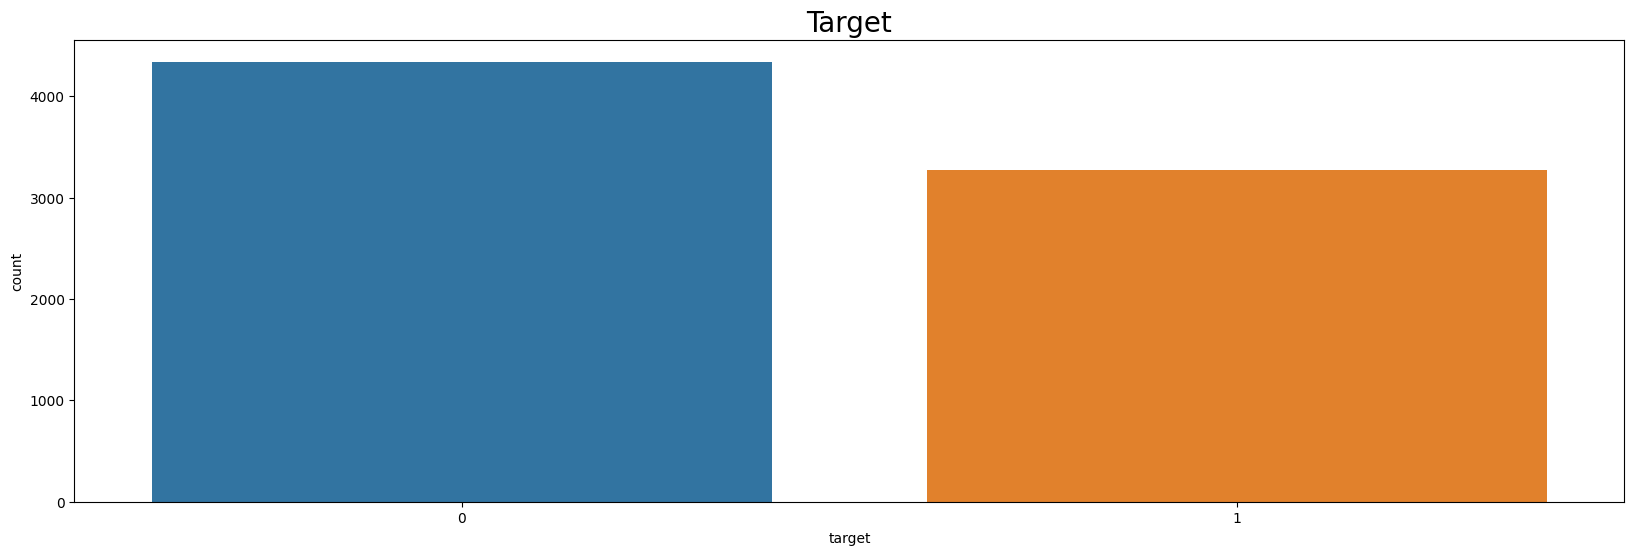

In [53]:
# Check if data is balanced
plt.figure(figsize=(20, 6))
ax = sns.countplot(x=df_train["target"])
ax.set_title("Target", fontsize=20)
plt.show()

In [54]:
# Print missing values
print(df_train.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


Note: location and keywords info is missing 

In [55]:
# Check the number of unique keywords
len(df_train['keyword'].unique())

222

In [56]:
# Print unique keywords
df_train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

Note: keywords may need cleaning

In [57]:
# Count a number of unique values for every keyword 
df_train['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

Note: disasters connected with water, fire, earthquakes, radiation - natural disasters
Conclusion: may need Topic Modelling with BERT for short-length text to identify areas  

In [58]:
# Count the num of locations
len(df_train['location'].unique())

3342

In [59]:
# Print out unique locations
locations = df_train['location'].unique().tolist()
print(locations)

[nan, 'Birmingham', 'Est. September 2012 - Bristol', 'AFRICA', 'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!', 'Paranaque City', 'Live On Webcam', 'milky way', 'GREENSBORO,NORTH CAROLINA', 'England.', 'Sheffield Township, Ohio', 'India', 'Barbados', 'Anaheim', 'Abuja', 'USA', 'South Africa', 'Sao Paulo, Brazil', 'hollywoodland ', 'Edmonton, Alberta - Treaty 6', 'Inang Pamantasan', 'Twitter Lockout in progress', 'Concord, CA', 'Calgary, AB', 'San Francisco', 'CLVLND', 'Nashville, TN', 'Santa Clara, CA', 'UK', 'St. Louis, MO', 'Walker County, Alabama', 'Australia', 'North Carolina', 'Norf Carolina', 'San Mateo County, CA', 'Njoro, Kenya', "Your Sister's Bedroom", 'Arlington, TX', 'South Bloomfield, OH', 'New Hanover County, NC', 'Maldives', 'Manchester, NH', 'Wilmington, NC', 'global', 'Alberta | Sask. | Montana', 'Charlotte', 'Baton Rouge, LA', 'Hagerstown, MD', 'Gloucestershire , UK', 'Nairobi, Kenya', 'Instagram - @heyimginog ', '304', 'Switzerland', 'US', 'Somewhere Onl

Note: location column may need cleaning (punctuations e.g. !!, | ,etc., digits if not lantitude, irrelevant or too general info e.g. 'milky way', 'Twitter Lockout in progress', "Your Sister's Bedroom", 'VISIT MY YOUTUBE CHANNEL.', etc.)

'y(our) boyfriends legs '
Somewhere Out There, not , a resident, 92, Worldwide happily Married with 2 kids, VISIT MY YOUTUBE CHANNEL, VISIT MY YOUTUBE CHANNEL. the own zone layer
Views From The Six, Swaning Around, Wild Wild Web, physically, Yeezy Taught Me , BIG D

In [60]:
# Check one tweet
df_train['text'][32]

'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw'

In [61]:
# Count a num of unique tweets
len(df_train['text'].unique())

7503

In [62]:
# Print the longest tweet
print("The longest tweet has: {} words".format(df_train['text'].apply(lambda x : len(x.split())).max()))

The longest tweet has: 31 words


In [63]:
# Print the shortest tweet
print("The shortest tweet has: {} words".format(df_train['text'].apply(lambda x : len(x.split())).min()))

The shortest tweet has: 1 words


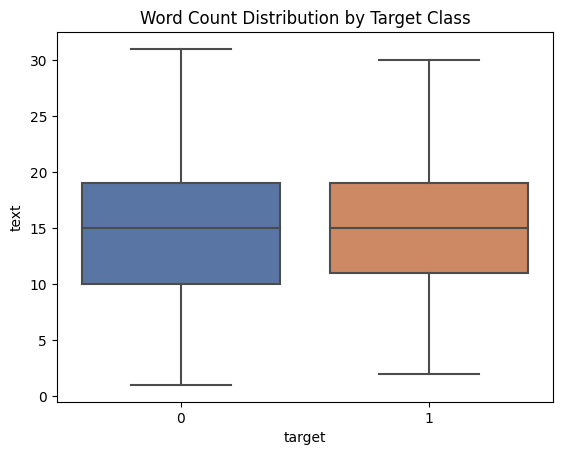

In [64]:
# Visualize length of tweets
sns.boxplot(data=df_train, x='target', y=df_train["text"].apply(lambda x : len(x.split())), palette='deep')
plt.title("Word Count Distribution by Target Class")
plt.show()

NOTE: there are no outliers 

## Data Preprocessing

In [66]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#Function to remove irrelevant data
def clean_tweet(tweet):

    """
    Regex expressions website https://regex101.com/
    """

    # Capital letters to lowercase
    tweet = tweet.lower()
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    # Remove user mentions
    tweet = re.sub(r'@[^\s]+', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    # Remove punctuation
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet)
    # Remove #RT
    tweet = re.sub(r'\b(rt)\b','',tweet)
    # Remove words containing numbers
    tweet = re.sub('\w*\d\w*' , '', tweet)
    # Remove single characters
    tweet = re.sub(r'\b[a-zA-Z]\b','',tweet)
    # Reduce repeated characters (e.g., "goooooaaaaal" to "goal")
    tweet = re.sub(r'(.)\1{2,}', r'\1\1', tweet)
    # Remove stopwords
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])

    return tweet

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anna_verbytska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
# Replace tweets with clean text
df_train['text'] = [clean_tweet(tweet) for tweet in df_train['text']]
df_train.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officers evacuation shelter place orders expected,1
3,6,NaN,NaN,people receive wildfires evacuation orders california,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pours school,1
5,8,NaN,NaN,rockyfire update california hwy closed directions due lake county fire cafire wildfires,1
6,10,NaN,NaN,flood disaster heavy rain causes flash flooding streets manitou colorado springs areas,1
7,13,NaN,NaN,im top hill see fire woods,1
8,14,NaN,NaN,theres emergency evacuation happening building across street,1
9,15,NaN,NaN,im afraid tornado coming area,1


In [27]:
#Function to remove irrelevant data
def clean_location(location):

    """
    Regex expressions website https://regex101.com/
    """

    location = str(location)
    # Capital letters to lowercase
    location = location.lower()
    # Remove URLs
    location = re.sub(r'http\S+', '', location)
    # Remove user mentions
    location = re.sub(r'@[^\s]+', '', location)
    # Remove hashtags
    location = re.sub(r'#([^\s]+)', r'\1', location)
    # Remove punctuation
    location = re.sub('[%s]' % re.escape(string.punctuation), '', location)
    # Remove #RT
    location = re.sub(r'\b(rt)\b','',location)
    # Remove words containing numbers
    location = re.sub('\w*\d\w*' , '', location)
    # Remove single characters
    location = re.sub(r'\b[a-zA-Z]\b','',location)
    # Reduce repeated characters
    location = re.sub(r'(.)\1{2,}', r'\1\1', location)
    # Remove stopwords
    location = ' '.join([word for word in location.split() if word not in stop_words])
    

    return location

In [68]:
# Replace tweets with clean text
df_train['location'] = [clean_location(location) for location in df_train['location']]
df_train['location'].unique()

array(['nan', 'birmingham', 'est september bristol', ..., 'denton texas',
       'newcastleupontyne uk', 'lincoln'], dtype=object)

In [69]:
# Decode the URL-encoded string to clean keyword column
from urllib.parse import unquote
df_train['keyword'] = df_train['keyword'].apply(lambda x: unquote(x) if isinstance(x, str) else x)
df_train['keyword'].unique()


array([nan, 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'burning buildings', 'bush fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical emergency', 'cliff fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailment', 'desol

#### Extract GPE with NER for location column to clean from nonsense and from text to fill in missing values

#### Keyword extraction with KeyBERT

https://www.geeksforgeeks.org/keyword-extraction-methods-in-nlp/

In [73]:
#Installation

from keybert import KeyBERT

# Initialize the KeyBERT model
model = KeyBERT('distilbert-base-nli-mean-tokens')

# Load the data
text = df_train['text']

# Extract keywords
#keywords = model.extract_keywords(text)
# Function to extract keywords using KeyBERT
def extract_keywords(text):
    keywords = model.extract_keywords(text, top_n=3)  # Extract top 1 keyword
    return keywords[0][0] if keywords else None

# Print the keywords
print("Keywords:")
for keyword in keywords:
    print(keyword)

Keywords:
[('earthquake', 0.638), ('allah', 0.5615), ('forgive', 0.5261), ('deeds', 0.3739), ('reason', 0.3049)]
[('forest', 0.6954), ('canada', 0.6463), ('ronge', 0.3226), ('la', 0.3119), ('sask', 0.2225)]
[('evacuation', 0.5009), ('officers', 0.4163), ('orders', 0.4037), ('notified', 0.3968), ('residents', 0.3959)]
[('wildfires', 0.5182), ('california', 0.4431), ('evacuation', 0.3058), ('orders', 0.1131), ('receive', 0.0591)]
[('wildfires', 0.5087), ('alaska', 0.3873), ('ruby', 0.1414), ('smoke', 0.1339), ('school', 0.0782)]
[('wildfires', 0.5498), ('rockyfire', 0.3504), ('california', 0.3432), ('lake', 0.25), ('closed', 0.2468)]
[('flooding', 0.5953), ('flood', 0.5762), ('rain', 0.4781), ('disaster', 0.3376), ('flash', 0.2773)]
[('woods', 0.7115), ('hill', 0.5911), ('im', 0.4078)]
[('emergency', 0.5732), ('street', 0.5262), ('evacuation', 0.524), ('building', 0.4179), ('happening', 0.3126)]
[('tornado', 0.7809), ('afraid', 0.5161), ('coming', 0.2231), ('im', 0.1681), ('area', 0.126)

In [74]:
df_train['keyword'] = df_train['keyword'].combine_first(df_train['text'].apply(extract_keywords))
df_train.head(20)

,id,keyword,location,text,target
0,1,earthquake,nan,deds reason earthquake may alah forgive us,1
1,4,forest,nan,forest fire near la ronge sask canada,1
2,5,evacuation,nan,residents asked shelter place notified oficers evacuation shelter place orders expected,1
3,6,wildfires,nan,people receive wildfires evacuation orders california,1
4,7,wildfires,nan,got sent photo ruby alaska smoke wildfires pours schol,1
5,8,wildfires,nan,rockyfire update california hwy closed directions due lake county fire cafire wildfires,1
6,10,rain,nan,flod disaster heavy rain causes flash floding strets manitou colorado springs areas,1
7,13,hil,nan,im top hil se fire wods,1
8,14,evacuation,nan,theres emergency evacuation hapening building acros stret,1
9,15,tornado,nan,im afraid tornado coming area,1


In [75]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
stemmer = SnowballStemmer('english')
stemmer.stem(text)

#### Extract locations with NER

In [ ]:
# Import the spaCy model
nlp = en_core_web_md.load()